# Double Multiple Stripe Analysis (2MSA) for Single Degree of Freedom (SDOF) Oscillators

<img src="../../../../figures/intact-damaged.jpg" width="500" align="middle">

In [1]:
from rmtk.vulnerability.common import utils
import double_MSA_on_SDOF
import numpy
from rmtk.vulnerability.derivation_fragility.NLTHA_on_SDOF.read_pinching_parameters import read_parameters
import MSA_utils
%matplotlib inline

---
### Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf).

Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.

If the User wants to specify the cyclic hysteretic behaviour of the SDOF system, please input the path of the file where the hysteretic parameters are contained, using the variable `sdof_hysteresis`. The parameters should be defined according to the format described in the [RMTK manual](../../../../rmtk-docs.pdf). If instead default parameters want to be assumed, please set the `sdof_hysteresis` variable to `"Default"`

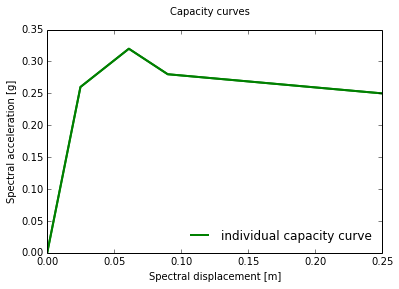

In [2]:
capacity_curves_file = '/Users/chiaracasotto/GitHub/phd_thesis/capacity_curves_Sd-Sa.csv'
sdof_hysteresis = "/Users/chiaracasotto/GitHub/phd_thesis/pinching_parameters.csv"

capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
hysteresis = read_parameters(sdof_hysteresis)

### Load ground motion records
For what concerns the ground motions to be used in the Double Multiple Stripe Analysis the following inputs are required:
 1. `gmrs_folder`: path to the folder containing the ground motion records to be used in the analysis. Each accelerogram needs to be in a separate CSV file as described in the [RMTK manual](../../../../rmtk-docs.pdf).
 2. `record_scaled_folder`. In this folder there should be a csv file for each Intensity Measure bin selected for the MSA, containing the names of the records that should be scaled to that IM bin, and the corresponding scaling factors. An example of this type of file is provided in the [RMTK manual](../../../../rmtk-docs.pdf).
 3. `no_bins`: number of Intensity Measure bins.
 4. `no_rec_bin`: number of records per bin
 5. `number_models_in_DS`: the number of model to populate each initial damage state with.

If a certain relationship wants to be kept between the ground motion characteristics of the mainshock and the aftershock, the variable `filter_aftershocks` should be set to `TRUE` and the following parameters should be defined:
 1. `Mw_multiplier`: the ratio between the aftershock magnitude and the mainshock magnitude.
 2. `waveform_path`: the path to the file containing for each gmr magnitude and predominant period;
Otherwise the variable `filter_aftershocks` should be set to `FALSE` and the aforementioned parameters can be left empty.
 
If the user wants to plot acceleration, displacement and velocity response spectra, the function `utils.plot_response_spectra(gmrs, minT, maxT)` should be un-commented. The parameters `minT` and `maxT` are used to define the period bounds when plotting the spectra for the provided ground motion fields.

In [3]:
gmrs_folder = '../../../../../rmtk_data/MSA_records'
number_models_in_DS = 1
no_bins = 2
no_rec_bin = 10
damping_ratio = 0.05
minT = 0.1
maxT = 2

filter_aftershocks = 'FALSE'
Mw_multiplier = 0.92
waveform_path = '../../../../../phd_thesis/waveform.csv'

gmrs = utils.read_gmrs(gmrs_folder)
gmr_characteristics = MSA_utils.assign_Mw_Tg(waveform_path, gmrs, Mw_multiplier, 
                                                   damping_ratio, filter_aftershocks)
#utils.plot_response_spectra(gmrs,minT,maxT)

### Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

Currently the user can provide `spectral displacement`, `capacity curve dependent` and `interstorey drift` damage model type.
If the damage model type is `interstorey drift` the user has to input interstorey drift values of the MDOF system. The user can then provide the pushover curve in terms of `Vb-dfloor` to be able to convert interstorey drift limit states to roof displacements and spectral displacements of the SDOF system, otherwise a linear relationship is assumed.

In [4]:
damage_model_file = "/Users/chiaracasotto/GitHub/phd_thesis/damage_model_ISD.csv"

damage_model = utils.read_damage_model(damage_model_file)

### Calculate fragility function

In order to obtain the fragility model, it is necessary to input the location of the damage model (`damage_model`), using the format described in the [RMTK manual](../../../../../rmtk-docs.pdf). It is as well necessary to input the damping value of the structure(s) under analysis and the value of the period (T) to be considered in the regression analysis. The method allows to consider or not degradation. Finally, if desired, it is possible to save the resulting fragility model in a .csv file.  

In [5]:
degradation = False
record_scaled_folder = "../../../../../phd_thesis/Scaling_Sa_4storey_EC8_v3_rmtk"

msa = MSA_utils.define_2MSA_parameters(no_bins,no_rec_bin,record_scaled_folder,filter_aftershocks)
PDM, Sds, gmr_info = double_MSA_on_SDOF.calculate_fragility(
                        capacity_curves, hysteresis, msa, gmrs, gmr_characteristics,
                        damage_model, damping_ratio,degradation, number_models_in_DS)

100%
Initial DS= 1
records_target1.csv
gmr n. 1 max disp. = 0.0208554 DS = 0
gmr n. 2 max disp. = 0.0202256 DS = 0
gmr n. 3 max disp. = 0.0180374 DS = 0
gmr n. 4 max disp. = 0.0155886 DS = 0
gmr n. 5 max disp. = 0.015386 DS = 0
gmr n. 6 max disp. = 0.0276796 DS = 0
gmr n. 7 max disp. = 0.0185962 DS = 0
gmr n. 8 max disp. = 0.0156193 DS = 0
gmr n. 9 max disp. = 0.0173107 DS = 0
gmr n. 10 max disp. = 0.0196917 DS = 0
records_target10.csv
gmr n. 11 max disp. = 0.171101 DS = 2
gmr n. 12 max disp. = 0.257631 DS = 3
gmr n. 13 max disp. = 0.172298 DS = 2
gmr n. 14 max disp. = 0.155495 DS = 2
gmr n. 15 max disp. = 0.16947 DS = 2
gmr n. 16 max disp. = 0.0812794 DS = 2
gmr n. 17 max disp. = 0.3669 DS = 3
gmr n. 18 max disp. = 0.48443 DS = 3
gmr n. 19 max disp. = 0.103032 DS = 2
gmr n. 20 max disp. = 0.336214 DS = 3
Initial DS= 2
records_target1.csv
gmr n. 21 max disp. = 0.0453677 DS = 1
gmr n. 22 max disp. = 0.0350112 DS = 1
gmr n. 23 max disp. = 0.0390824 DS = 1
gmr n. 24 max disp. = 0.0328368 

### Fit lognormal CDF fragility curves

The following parameters need to be defined in the cell below in order to fit lognormal CDF fragility curves to the damage probability matrix obtained above:
1. `IMT`: This parameter specifies the intensity measure type to be used. Currently supported options are `"PGA"`, `"Sa"`,`"Sd"` and `"HI"` (Housner Intensity).
2. `period`: This parameter defines the period for which a spectral intensity measure should be computed. If Housner Intensity is selected as intensity measure a range of periods should be defined instead (for example `T=np.arange(0.3,3.61,0.01)`).
3. `regression_method`: This parameter defines the regression method to be used for estimating the parameters of the fragility functions. The valid options are `"least squares"` and `"max likelihood"`.

In [6]:
IMT = 'Sa'
T = 0.47
#T = numpy.arange(0.4,1.91,0.01)
regression_method = 'max likelihood'
        
fragility_model = MSA_utils.calculate_fragility_model_damaged( PDM,gmrs,gmr_info,IMT,msa,damage_model,
                                                                        T,damping_ratio, regression_method)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 60
         Function evaluations: 127
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 24
         Function evaluations: 66


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/distributions.py:7184: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/distributions.py:7184: RuntimeWarning: invalid value encountered in less_equal
  return (n >= 0) & (p >= 0) & (p <= 1)


### Plot fragility functions

The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

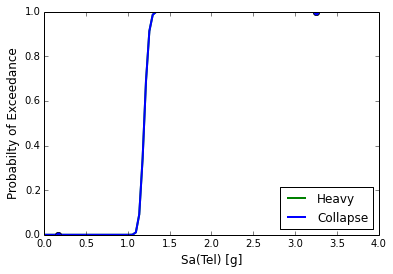

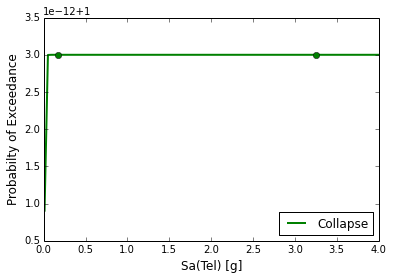

In [7]:
minIML, maxIML = 0.01, 4

MSA_utils.plot_fragility_model(fragility_model,damage_model,minIML, maxIML)

### Save fragility functions
 
The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
 1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
 2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
 3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [8]:
output_type = "csv"
output_path = "../../../../../rmtk_data/"
minIML, maxIML = 0.01, 4
tax = 't'

MSA_utils.save_mean_fragility(fragility_model,damage_model,tax,output_type,output_path,minIML, maxIML)